# Корреляция стоимости криптовалют и акций

Мы посмотрим как коррелируют между собой стоимость криптовалюты и акции между собой. Для этого мы загрузим семь криптовалют, 30 акций и индекс S&P 500. По пять акций будут относиться к технологическим, финансовым, энергетическим и ретейл-компаниям, а 10 к Small-Cap компаниям (с капитализацией до $2 млрд).

Ход работы: 

1. загрузка данных;
2. предобработка;
3. анализ: познакомимся с данными криптовалют, посмотрим историческую динамику цен, распределение, среднюю и медиану, а также посчитаем корреляцию между криптовалютами;
4. расчет корреляции между акциями и криптой.

# Загрузка библиотек и данных

In [1]:
# Загружаем бибилиотеки
import pandas as pd
from datetime import datetime
from yahooquery import Ticker
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

## Криптовалюты

Загрузим следующие криптовалюты:

1. Bitcoin 
2. Ethereum 
3. Cardano
4. Binance Coin
5. Tron
6. Dogecoin
7. Ripple


In [2]:
# определяем тикеры криптовалют
crypto_tickers = 'BTC-USD ETH-USD ADA-USD BNB-USD TRX-USD DOGE-USD XRP-USD'

start_date = '2013-01-01'
end_date = '2023-10-08'
#datetime.today().strftime('%Y-%m-%d')  # Current date

crypto_ticker = Ticker(crypto_tickers)

# извлекаем исторические данные
cryptocurrencies = crypto_ticker.history(start=start_date, end=end_date)

# сбрасываем мультииндексы
cryptocurrencies = cryptocurrencies.reset_index()

Мы загрузили данные, начиная с начала 2013 года по 10 октября 2023 года - более, чем за 10 лет. Но криптовалют в это время могло и не быть. Узнаем какие даты охватывают извлеченные данные по каждой из криптовалют

In [3]:
# проходимся циклом по каждой криптовалюте
for cryptocurrency in cryptocurrencies['symbol'].unique():
    # фультруем данные по каждой криптовалюте отдельно
    cryptocurrency_data = cryptocurrencies[cryptocurrencies['symbol'] == cryptocurrency]
    
    # определяем минимальную и максимульную даты
    max_date = cryptocurrency_data['date'].max()
    min_date = cryptocurrency_data['date'].min()
    
    # выводим результаты на экран
    print(f"For {cryptocurrency}:")
    print(f"Maximum Date: {max_date}")
    print(f"Minimum Date: {min_date}")
    print()

For BTC-USD:
Maximum Date: 2023-10-07
Minimum Date: 2014-09-17

For ETH-USD:
Maximum Date: 2023-10-07
Minimum Date: 2017-11-09

For ADA-USD:
Maximum Date: 2023-10-07
Minimum Date: 2017-11-09

For BNB-USD:
Maximum Date: 2023-10-07
Minimum Date: 2017-11-09

For TRX-USD:
Maximum Date: 2023-10-07
Minimum Date: 2017-11-09

For DOGE-USD:
Maximum Date: 2023-10-07
Minimum Date: 2017-11-09

For XRP-USD:
Maximum Date: 2023-10-07
Minimum Date: 2017-11-09



Кроме биоткоина, все минимальная возможная дата для анализа для криптовалют - это ноябрь 2017 года. Для биткоина - сентябрь 2014.

Удалим данные, которые раньше 9 ноября 2017 года

In [4]:
cryptocurrencies['date'] = pd.to_datetime(cryptocurrencies['date'])
cryptocurrencies = cryptocurrencies.query('date >= "2017-11-09"')

cryptocurrencies['date'].min()

Timestamp('2017-11-09 00:00:00')

## Акции и индекс S&P500 

Мы загрузим разные, относящиеся к разным секторам фондового рынка. От каждого сектора мы загрузим по 5 акций. В дополнение, мы извлечем  десять [small-cap акции](https://www.investopedia.com/terms/s/small-cap.asp) - это такие акции, капитализация которых от 250 млн долларов до 2 миллиардов долларов.

Small-cap акции:

1. Beyond Meat, Inc.: BYND
2. Twilio Inc.: TWLO
3. Zillow Group, Inc.: Z
4. The Trade Desk, Inc.: TTD
5. PagerDuty, Inc.: PD
6. Etsy, Inc.: ETSY
7. HubSpot, Inc.: HUBS
8. Square, Inc.: SQ
9. Okta, Inc.: OKTA
10. MongoDB, Inc.: MDB

In [5]:
# определяем тикеры small-capp 
small_cap_tickers = 'BYND TWLO Z TTD PD ETSY HUBS SQ OKTA MDB'

start_date = '2017-11-09'
end_date = '2023-10-08'

# извлекаем исторические данные за выбранный промежуток времени
small_cap_ticker = Ticker(small_cap_tickers)
small_cap = small_cap_ticker.history(start=start_date, end=end_date)

small_cap = small_cap.reset_index()

Big Tech Companies:

1. Apple Inc.: AAPL
2. Microsoft Corporation: MSFT
3. Amazon.com, Inc.: AMZN
4. Alphabet Inc. (Google): GOOGL
5. Facebook, Inc.: FB

Finance Companies:

1. JPMorgan Chase & Co.: JPM
2. Bank of America Corporation: BAC
3. Wells Fargo & Co.: WFC
4. Goldman Sachs Group, Inc.: GS
5. Morgan Stanley: MS

Retail Companies:

1. Walmart Inc.: WMT
2. Amazon.com, Inc.: AMZN
3. The Home Depot, Inc.: HD
4. Costco Wholesale Corporation: COST
5. Target Corporation: TGT

Energy Companies:
1. Exxon Mobil Corporation: XOM
2. Chevron Corporation: CVX
3. ConocoPhillips: COP
4. Schlumberger Limited: SLB
5. Phillips 66: PSX

S&P500

In [6]:
# определяем тикеры для разных групп акций
big_tech_tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'FB']
finance_tickers = ['JPM', 'BAC', 'WFC', 'GS', 'MS']
retail_tickers = ['WMT', 'AMZN', 'HD', 'COST', 'TGT']
energy_tickers = ['XOM', 'CVX', 'COP', 'SLB', 'PSX']

# тикер S&P 500
sp500_ticker = '^GSPC'

# создадим функцию для ускоренного извлечения данных
def fetch_ticker_data(tickers):

    ticker = Ticker(tickers)
    data = ticker.history(start='2017-11-09', end='2023-10-08')
    return data

# извлекаем исторические данные
big_tech_data = fetch_ticker_data(big_tech_tickers)
finance_data = fetch_ticker_data(finance_tickers)
retail_data = fetch_ticker_data(retail_tickers)
energy_data = fetch_ticker_data(energy_tickers)

sp500  = fetch_ticker_data(sp500_ticker)

#сбросим мультииндекс
sp500 = sp500.reset_index()

big_tech_data=big_tech_data.reset_index()
finance_data = finance_data.reset_index()
retail_data = retail_data.reset_index()
energy_data = energy_data.reset_index()

# переводим столбец с датой к временному типу данных
big_tech_data['date'] = pd.to_datetime(big_tech_data['date'])
finance_data['date'] = pd.to_datetime(finance_data['date'])
retail_data['date'] = pd.to_datetime(retail_data['date'])
energy_data['date'] = pd.to_datetime(energy_data['date'])
sp500['date'] = pd.to_datetime(sp500['date'])

small_cap['date'] = pd.to_datetime(small_cap['date'])


# Предобработка

Выполним небольшую предобработку 

Посмотрм сколько строк для каждой криптовалюты, акции и индекса S&P 500

In [7]:
big_tech_data['symbol'].iloc[2000]

'MSFT'

In [8]:
# создадим отдельно переменную, где будут храниться уникальные наименования криптовалют в нашей таблице
# созданной переменной мы будем и в дальнейшем пользоваться
cryptos = cryptocurrencies['symbol'].unique()

# считаем количество строк для каждой криптовалюты
for crypto in cryptos:
    num_rows_crypto = len(cryptocurrencies[cryptocurrencies['symbol'] == crypto])
    
    # выводим на экран кол-во строк
    print(f"Number of rows for {crypto}: {num_rows_crypto}")

# список с датасетами акций разных категорий и индекса
stock_datasets = [big_tech_data, finance_data, retail_data, energy_data, small_cap, sp500]

# проходимся циклом по каждому датасету
for df in stock_datasets:
    
    # извлекаем названия акций в каждом датасете
    unique_symbols = df['symbol'].unique()
    
    # считаем кол-во строк для каждой акции в датасете
    for symbol in unique_symbols:
        num_rows_share = len(df[df['symbol'] == symbol])
        print(f"Number of rows for {symbol}: {num_rows_share}")


Number of rows for BTC-USD: 2159
Number of rows for ETH-USD: 2159
Number of rows for ADA-USD: 2159
Number of rows for BNB-USD: 2159
Number of rows for TRX-USD: 2159
Number of rows for DOGE-USD: 2159
Number of rows for XRP-USD: 2159
Number of rows for AAPL: 1487
Number of rows for MSFT: 1487
Number of rows for AMZN: 1487
Number of rows for GOOGL: 1487
Number of rows for JPM: 1487
Number of rows for BAC: 1487
Number of rows for WFC: 1487
Number of rows for GS: 1487
Number of rows for MS: 1487
Number of rows for WMT: 1487
Number of rows for AMZN: 1487
Number of rows for HD: 1487
Number of rows for COST: 1487
Number of rows for TGT: 1487
Number of rows for XOM: 1487
Number of rows for CVX: 1487
Number of rows for COP: 1487
Number of rows for SLB: 1487
Number of rows for PSX: 1487
Number of rows for BYND: 1117
Number of rows for TWLO: 1487
Number of rows for Z: 1487
Number of rows for TTD: 1487
Number of rows for PD: 1131
Number of rows for ETSY: 1487
Number of rows for HUBS: 1487
Number of

Мы осуществили расчет количества строк для каждой акции, криптовалюты и индекса S&P500. Мы видим расхождения: у каждой из криптовалют 2159 строк, а у каждой акции и индекса S&P500 по 1487. Исключения составляют акции компаний Beyond Meat (1117 строк) и PagerDuty (1131). Обе компании относятся к small-cap и, вероятно, появились недавно.

Проверим дубликаты по дате

In [9]:
cryptos

array(['BTC-USD', 'ETH-USD', 'ADA-USD', 'BNB-USD', 'TRX-USD', 'DOGE-USD',
       'XRP-USD'], dtype=object)

In [10]:
cryptocurrencies[cryptocurrencies['symbol'] == "BNB-USD"]['date'].duplicated().any()

False

In [11]:
# проходимся циклом по списку с уникальными названиями криптовалют
for crypto in cryptos:
    # создаем переменную, где будет храниться серия из булевых значений, где значение true - это дублированная дата
    duplicate_dates_crypto = cryptocurrencies[cryptocurrencies['symbol'] == crypto]['date'].duplicated()
    # создаем переменную, где будет храниться одно булево значение. В случае обнаружения в серии с дубликами хоть одного
    # дубликата, - переменная будет содержать значение True
    has_duplicates_crypto = duplicate_dates_crypto.any()
    # выводим на экрен результаты проверки
    print(f"\nFor {crypto}, are there duplicate dates: {has_duplicates_crypto}")

# проверяем на наличие дубликатов по дате каждую из акций. Проходимся циклом по датасетам с акциями
for df in stock_datasets:
    print("\nChecking duplicates for stocks:")
    
    # извлекаем уникальные названия акций из датасета
    unique_symbols = df['symbol'].unique()
    
    # проходимся во внутреннем цикле по каждой из акций 
    for symbol in unique_symbols:
        # фильтруем таблицу: извлекаем данные каждой из акций из таблицы
        stock_df = df[df['symbol'] == symbol]
        
        # проверяем на наличие дубликатов по дате
        duplicate_dates_stock = stock_df[stock_df.duplicated(subset=['date'], keep=False)]
        
        # выводим результаты проверки на экран
        if not duplicate_dates_stock.empty:
            print(f"For {symbol}, there are duplicate dates:")
            print(duplicate_dates_stock)
        else:
            print(f"For {symbol}, there are no duplicate dates.")




For BTC-USD, are there duplicate dates: False

For ETH-USD, are there duplicate dates: False

For ADA-USD, are there duplicate dates: False

For BNB-USD, are there duplicate dates: False

For TRX-USD, are there duplicate dates: False

For DOGE-USD, are there duplicate dates: False

For XRP-USD, are there duplicate dates: False

Checking duplicates for stocks:
For AAPL, there are no duplicate dates.
For MSFT, there are no duplicate dates.
For AMZN, there are no duplicate dates.
For GOOGL, there are no duplicate dates.

Checking duplicates for stocks:
For JPM, there are no duplicate dates.
For BAC, there are no duplicate dates.
For WFC, there are no duplicate dates.
For GS, there are no duplicate dates.
For MS, there are no duplicate dates.

Checking duplicates for stocks:
For WMT, there are no duplicate dates.
For AMZN, there are no duplicate dates.
For HD, there are no duplicate dates.
For COST, there are no duplicate dates.
For TGT, there are no duplicate dates.

Checking duplicates 

Мы произвели проверку дубликатов по дате для каждой криптовалюты, акции и индекса S&P500. Дубликатов не обнаружено: каждая дата является уникальной.

In [12]:
# Оставим только столбцы с тикером, датой и adjclose

big_tech_data = big_tech_data[['symbol', 'date', 'adjclose']].copy()
finance_data = finance_data[['symbol','date', 'adjclose']].copy()
retail_data = retail_data[['symbol','date', 'adjclose']].copy()
energy_data = energy_data[['symbol','date', 'adjclose']].copy()
sp500 = sp500[['symbol','date', 'adjclose']].copy()
cryptocurrencies = cryptocurrencies[['symbol','date', 'adjclose']].copy()

small_cap = small_cap[['symbol','date', 'adjclose']].copy()



# отстортируем данные по дате и тикеру
big_tech_data.sort_values(['symbol', 'date'], inplace=True)
finance_data.sort_values(['symbol', 'date'], inplace=True)
retail_data.sort_values(['symbol', 'date'], inplace=True)
energy_data.sort_values(['symbol', 'date'], inplace=True)
sp500.sort_values(['symbol', 'date'], inplace=True)
cryptocurrencies.sort_values(['symbol', 'date'], inplace=True)

small_cap.sort_values(['symbol', 'date'], inplace=True)


Посчитаем доход по следующей формуле:



$$
\text{Return}_{t} = \left( \frac{\text{Price}_{t} - \text{Price}_{t-1}}{\text{Price}_{t-1}} \right) \times 100
$$



In [13]:

# Считаем доходность
def calculate_returns(df):
    # считаем ежедневный доход для каждой из акций по столбцу adjclose
    df['returns'] = df.groupby('symbol')['adjclose'].pct_change() * 100
    return df

# прикладываем созданную функцию к датасетам с акциями и индексом
big_tech_data = big_tech_data.groupby('symbol').apply(calculate_returns)
finance_data = finance_data.groupby('symbol').apply(calculate_returns)
retail_data = retail_data.groupby('symbol').apply(calculate_returns)
energy_data = energy_data.groupby('symbol').apply(calculate_returns)
cryptocurrencies = cryptocurrencies.groupby('symbol').apply(calculate_returns)
sp500['returns'] = sp500['adjclose'].pct_change() * 100

small_cap = small_cap.groupby('symbol').apply(calculate_returns)


# заполним первое значение нулем вместо nan
big_tech_data['returns'] = big_tech_data['returns'].fillna(0)
finance_data['returns'] = finance_data['returns'].fillna(0)
retail_data['returns'] = retail_data['returns'].fillna(0)
energy_data['returns'] = energy_data['returns'].fillna(0)
sp500['returns'] = sp500['returns'].fillna(0)
cryptocurrencies['returns'] = cryptocurrencies['returns'].fillna(0)

small_cap['returns'] = small_cap['returns'].fillna(0)


# Анализ

## Историческая стоимость криптовалю

Давайте посмотрим на динамику цен в долларах на криптовалюты

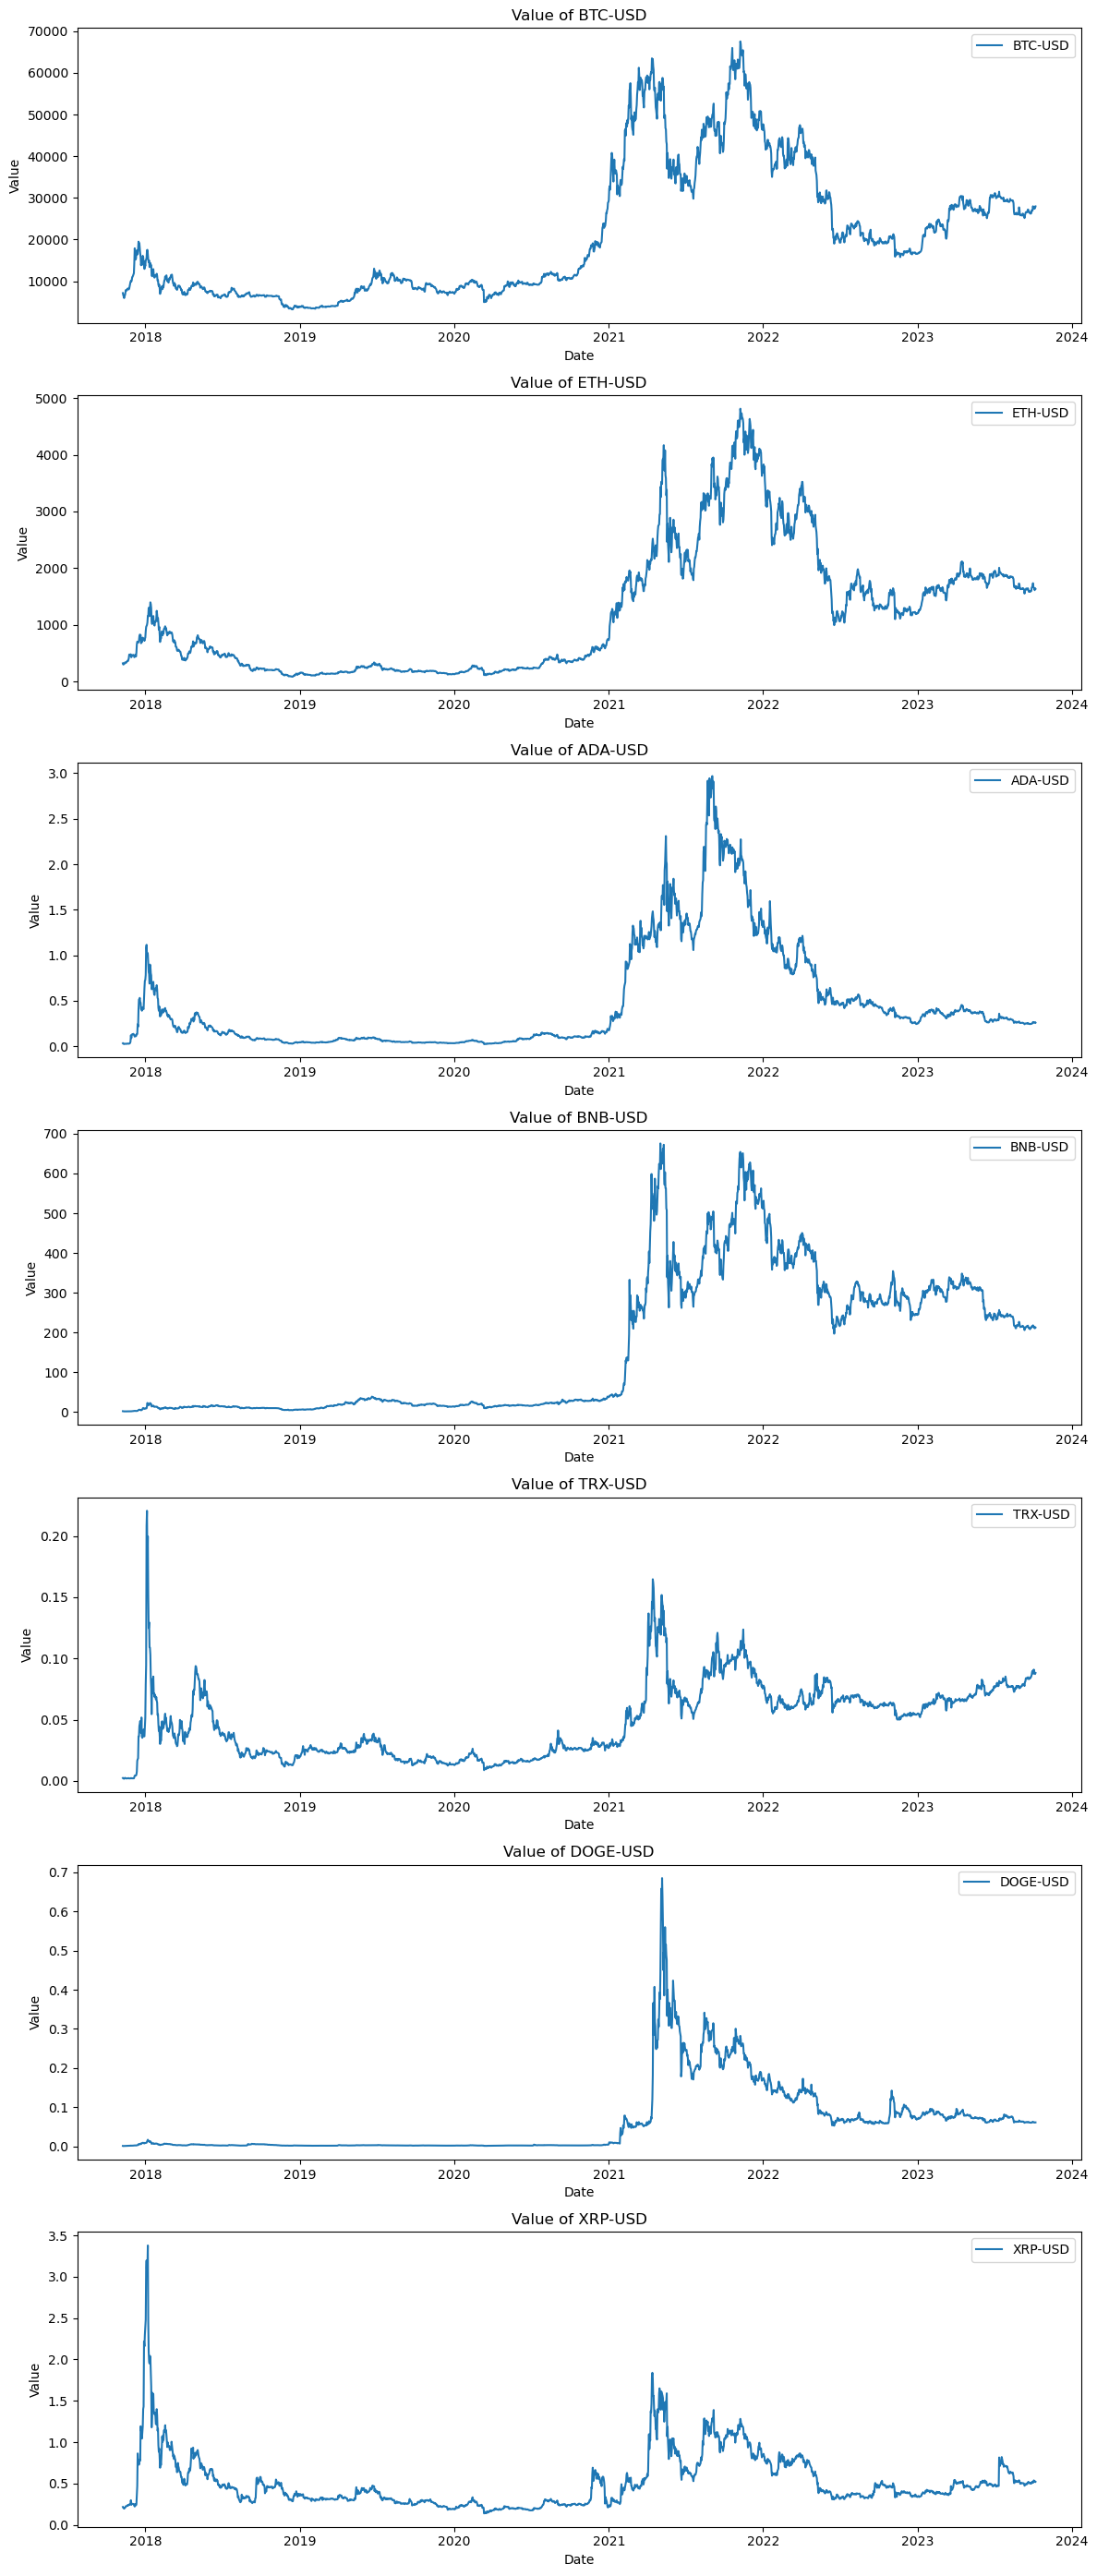

In [14]:

# создаем субплот
fig, axs = plt.subplots(nrows=len(cryptos), figsize=(12, 4*len(cryptos)))

# проходимся циклом по списку с названиями криптовалют
for i, cryptocurrency in enumerate(cryptos):
    # фильтруем таблицу с криптой по каждой криптовалюте отдельно
    cryptocurrency_data = cryptocurrencies[cryptocurrencies['symbol'] == cryptocurrency]
    
    # настраиваем оси нашего графика
    axs[i].plot(cryptocurrency_data['date'], cryptocurrency_data['adjclose'], label=cryptocurrency)
    axs[i].set_title(f'Value of {cryptocurrency}')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Value')
    axs[i].legend()


plt.tight_layout()

plt.show()

Извлеченные данные охватывают все важные событий в истории криптовалют:

1. Обвал в начала 2018 года. Падение стоимости криптовалют не затронуло Dogecoin и Binance Coin.
2. [Криптовалютную зиму](https://www.forbes.com/advisor/investing/cryptocurrency/what-is-crypto-winter/) - период с 2018 до 2021 год, когда криптовалютный рынок не рос. 
3. [Подъем 2021 года](https://www.cnbc.com/2021/12/27/12-key-moments-that-fueled-cryptos-record-growth-in-2021.html) 
4. Последовавшее за обвалом Terra и FTX падение в мае 2022 года

## Частотность значений

Посмотрим как часто встречаются различные значения стоимости стоимости криптовалют. Визуализируем частотную гистограмму

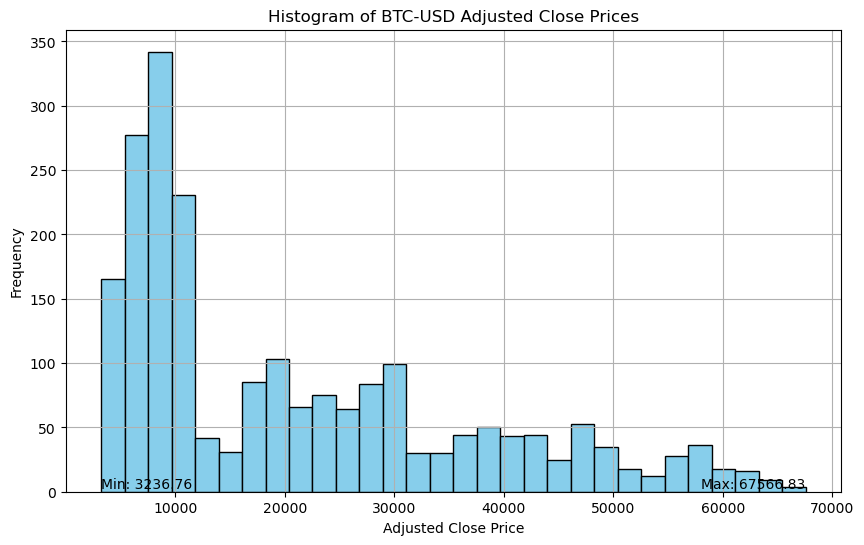

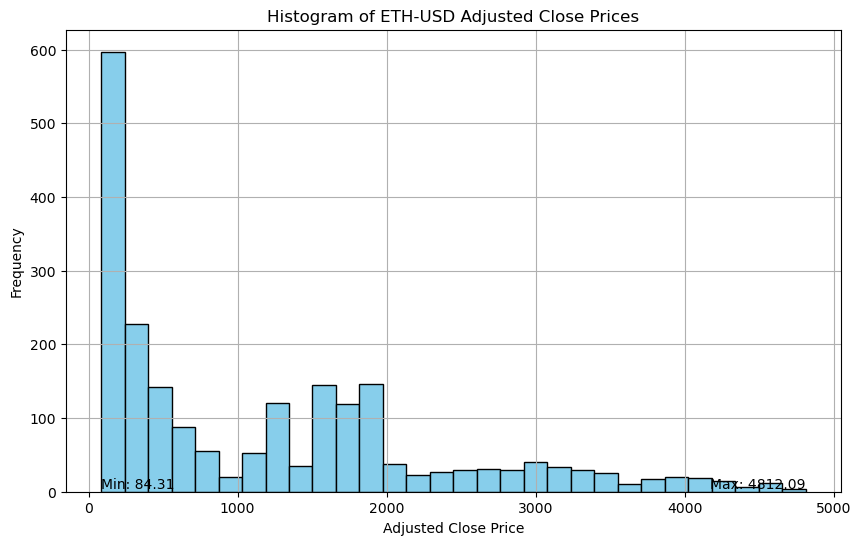

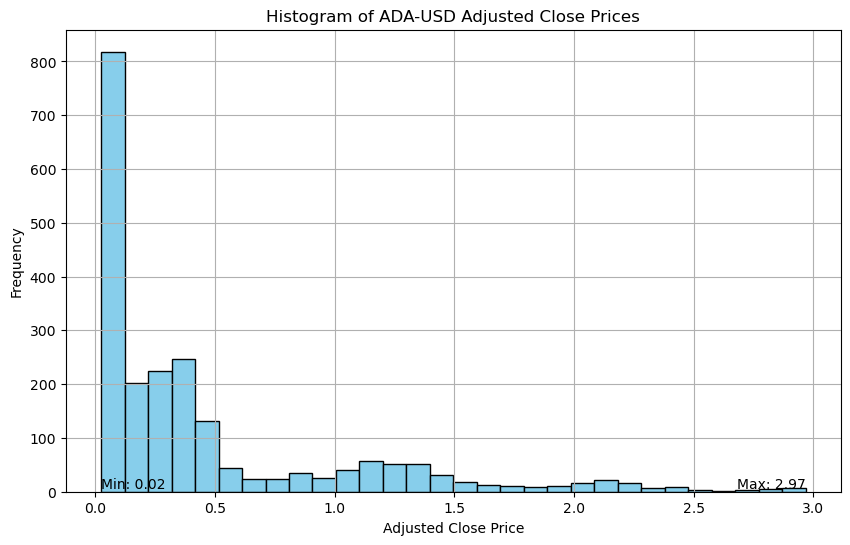

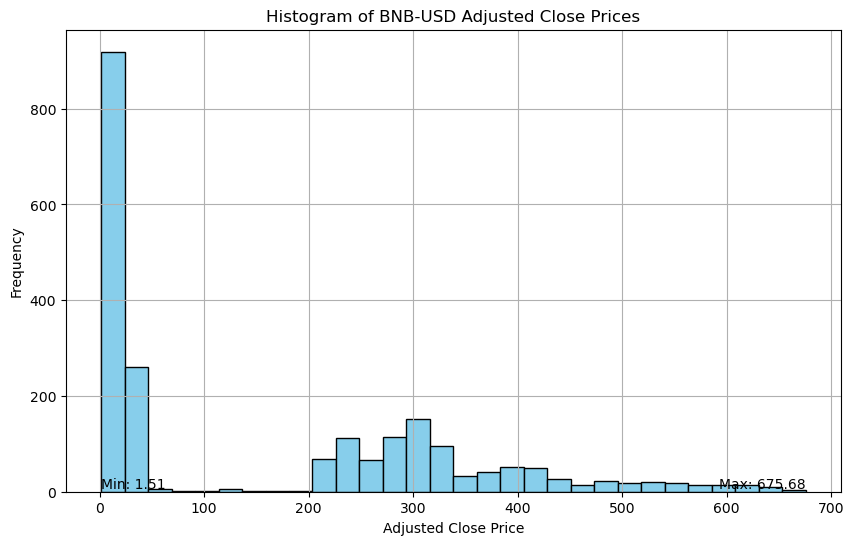

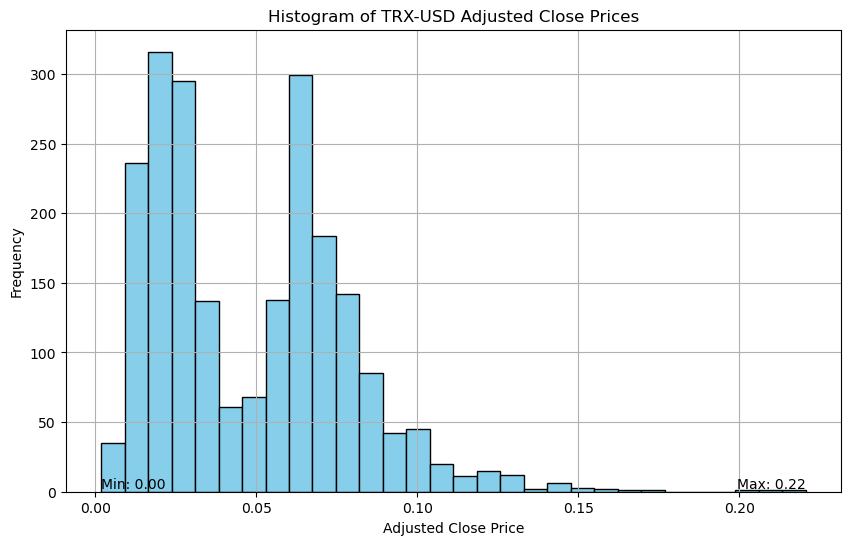

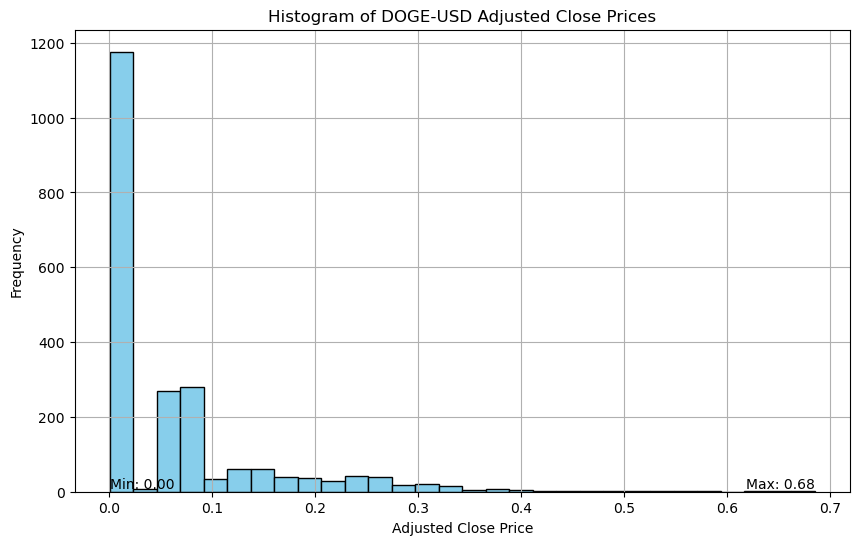

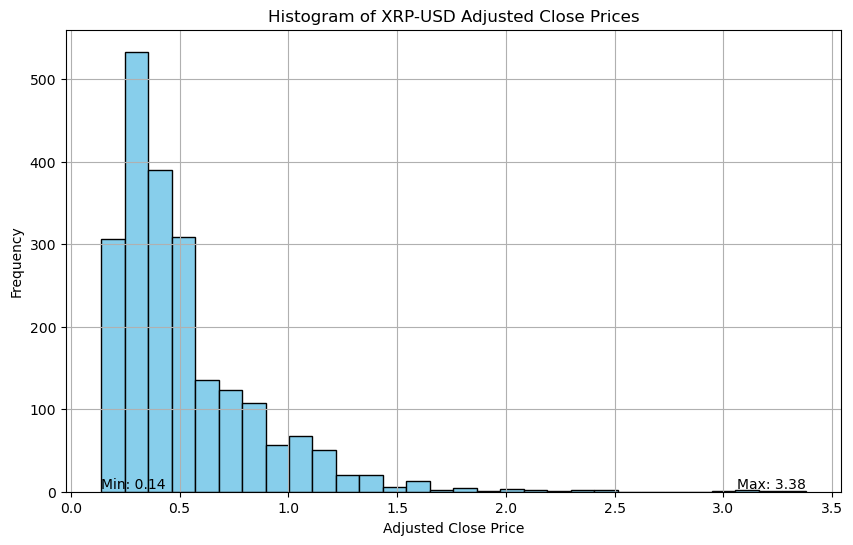

In [16]:
# зададим кол-во корзин для гистограммы
num_bins = 30

# проходимся по списку с уникальными названиями криптовалют
for crypto_symbol in cryptos:
    crypto_data = cryptocurrencies[cryptocurrencies['symbol'] == crypto_symbol]

    # создаем график для каждой криптовалюты
    plt.figure(figsize=(10, 6))
    
    # создаем гистограмму для значений adjclose
    plt.hist(crypto_data['adjclose'], bins=num_bins, color='skyblue', edgecolor='black')
    
    # подпишем на каждом графике заголовок и названия осей.
    plt.title(f'Histogram of {crypto_symbol} Adjusted Close Prices')
    plt.xlabel('Adjusted Close Price')
    plt.ylabel('Frequency')
    
    #  отобразим максимальное и и минимальное значение на графике
    min_val = crypto_data['adjclose'].min()
    max_val = crypto_data['adjclose'].max()
    plt.text(min_val, 0, f'Min: {min_val:.2f}', verticalalignment='bottom', horizontalalignment='left')
    plt.text(max_val, 0, f'Max: {max_val:.2f}', verticalalignment='bottom', horizontalalignment='right')
    
    plt.grid(True)
    plt.show()


Все криптовалюты, кроме Tron, имеют положительную ассиметрию. Что это значит?

1. Существует небольшое количество отличительно выскоих значений, которые тянут хвост гистограммы вправо. То есть большая часть значений стоимости криптовалют имеет небольшую стоимость в диапозоне минимума и максимума конкретной криптовалюты.
2. Средняя стоимость крипты будет выше медианной, поскольку высокие значения будут тянуть среднее вверх
3. Положительная ассиметрия может свидетльствовать о волатильности криптовалюты, как актива: крайние редкие значения могут приводить к неожиданным скачкам или к более ожидаемым падениям.
4. Профессиональные игроки фондового рынка могут учесть положительную ассиметрию для выстраивания своих стратегий. Например, использовать опционы, которые бы извлекли выгоду от динамики резких взлетов цены или, напротив, рассмаотреть защитные меры от резких колебаний
5. При использовании в нашем анализе статистических тестов нам было бы важно учесть особенности распределния для того, чтобы подобрать нужный тест, поскольку многие тесты предполагают нормальное распределение и использование в качестве меры центральной тенденции среднего, которое в нашем случае, искажено немногичесленными выскоими значениями.




Распределение Tron имеет бимодальную форму, с двумя локальными пиками частот. Первый пик в районе 0,021 доллара, второй в районе 0,064 доллара. 

## Минимальная и максимальная стоимость криптовалюты

Установим день и значение максимального и минимального значения стоимости криптовалюты

In [17]:
min_max_crypto_price = cryptocurrencies.groupby(['symbol', 'date']).agg({'adjclose': ['min', 'max']})

In [18]:
min_max_prices = cryptocurrencies.groupby('symbol')['adjclose'].agg([('min_date', 'idxmin'), ('min_price', 'min'), ('max_date', 'idxmax'), ('max_price', 'max')])

min_max_prices['min_date'] = cryptocurrencies.loc[min_max_prices['min_date'], 'date'].values
min_max_prices['max_date'] = cryptocurrencies.loc[min_max_prices['max_date'], 'date'].values

min_max_prices = min_max_prices.reset_index()
min_max_prices = min_max_prices.sort_values(by=['min_date', 'max_date'], ascending=True)

In [19]:
min_max_prices.style.background_gradient(cmap='Blues_r')

,symbol,min_date,min_price,max_date,max_price
5,TRX-USD,2017-11-12 00:00:00,0.001783,2018-01-05 00:00:00,0.220555
3,DOGE-USD,2017-11-12 00:00:00,0.001038,2021-05-07 00:00:00,0.684777
1,BNB-USD,2017-11-17 00:00:00,1.510360,2021-05-03 00:00:00,675.684082
4,ETH-USD,2018-12-14 00:00:00,84.308296,2021-11-08 00:00:00,4812.087402
2,BTC-USD,2018-12-15 00:00:00,3236.761719,2021-11-08 00:00:00,67566.828125
6,XRP-USD,2020-03-12 00:00:00,0.139635,2018-01-07 00:00:00,3.377810
0,ADA-USD,2020-03-12 00:00:00,0.023961,2021-09-03 00:00:00,2.968239


Как мы видим, минимумы и максимумы цены одной криптовалюты находятся  почти всегда в очень близком диапозоне дат с мин. и макс. других криптовалют. 

**Минимальная цена** 

В 2017 году 12 и 17 ноября были у Tron, Dogecoin и Binance.

В 2018 году 14 и 15 декабря у Bitcoin и Ethereum. 

В 2020 году 12 марта у Riple и Cardano. 

**Максимальная цена** 

В 2018 году 5 и 7 января была у Tron и Riple.

В 2021 3 и 7 мая у Binance и Dogecoin;3 сентября у Cardano; 8 ноября у Bitcoin и Ethereum. 


Можем отметить Bitcoin и Ethereum, которые достигают ценового пика в один день и дна с разницей в одни сутки.

## Средняя и медианная стоимость риптовалюты

In [20]:
mean_median_price = cryptocurrencies.groupby('symbol').agg({'adjclose':['mean', 'median']}).reset_index()

mean_median_price.columns = mean_median_price.columns.droplevel(0)
mean_median_price = mean_median_price.rename(columns={"": "symbol"})
mean_median_price['diff'] = mean_median_price['mean'] - mean_median_price['median']
mean_median_price['percent'] = round(mean_median_price['diff'] / mean_median_price['mean'] * 100, 2)

In [21]:
mean_median_price.sort_values(by='percent', ascending=True)

,symbol,mean,median,diff,percent
5,TRX-USD,0.048415,0.045417,0.002998,6.19
6,XRP-USD,0.519474,0.414673,0.104801,20.17
2,BTC-USD,20925.409879,15599.200195,5326.209683,25.45
4,ETH-USD,1208.273475,773.835999,434.437476,35.96
0,ADA-USD,0.469191,0.256230,0.212961,45.39
1,BNB-USD,163.390474,31.097898,132.292575,80.97
3,DOGE-USD,0.062470,0.005981,0.056489,90.43


Как мы видим, разница между средним и медианой большая. Для таких криптовалют как Dogecoin и Binance она доходит до 90% и 81%. 

Самая низкая разница у криптовалюты Tron - 6%

У популярных Bitcoin и Ethereum разница между медианой и средним достигает 25 и 36 процентов соответственно

Посмотрим на среднюю и медиану по году

In [22]:
cryptocurrencies['year'] = cryptocurrencies['date'].dt.year

In [23]:
crypt_mean_median = cryptocurrencies.groupby(['symbol', 'year']).agg({'adjclose':['mean', 'median']}).reset_index()

In [24]:
#crypt_mean_median.columns = crypt_mean_median.columns.droplevel(0)

crypt_mean_median.columns = ['symbol', 'year'] + list(crypt_mean_median.columns.get_level_values(1)[2:])


In [25]:
crypt_mean_median['diff'] = crypt_mean_median['mean'] - crypt_mean_median['median']
crypt_mean_median['percent'] = round(crypt_mean_median['diff'] / crypt_mean_median['mean'] * 100, 2)
crypt_mean_median = crypt_mean_median.sort_values(by='year', ascending=True)

In [26]:
crypt_mean_median.style.background_gradient(cmap='Blues_r')

,symbol,year,mean,median,diff,percent
0,ADA-USD,2017,0.201029,0.119883,0.081146,40.370000
21,DOGE-USD,2017,0.003750,0.002479,0.001271,33.900000
28,ETH-USD,2017,532.086680,470.204010,61.882670,11.630000
42,XRP-USD,2017,0.575206,0.252393,0.322813,56.120000
7,BNB-USD,2017,3.483209,2.491680,0.991529,28.470000
35,TRX-USD,2017,0.015069,0.002485,0.012584,83.510000
14,BTC-USD,2017,12283.936413,11916.700195,367.236218,2.990000
1,ADA-USD,2018,0.209573,0.150960,0.058613,27.970000
29,ETH-USD,2018,483.507727,453.917999,29.589727,6.120000
43,XRP-USD,2018,0.666274,0.506698,0.159576,23.950000


Визуализируем среднюю и медиану для каждой из крипты по году

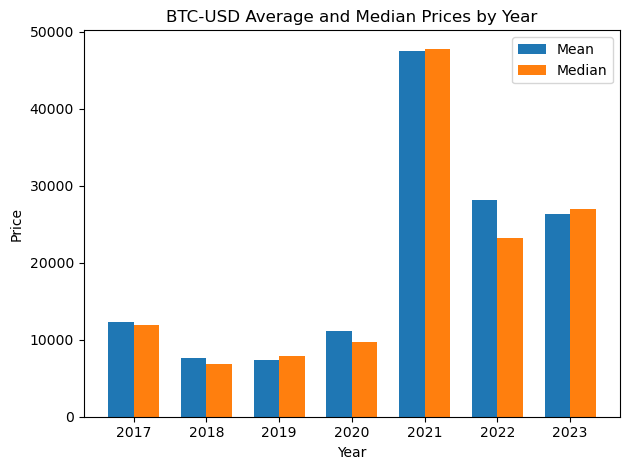

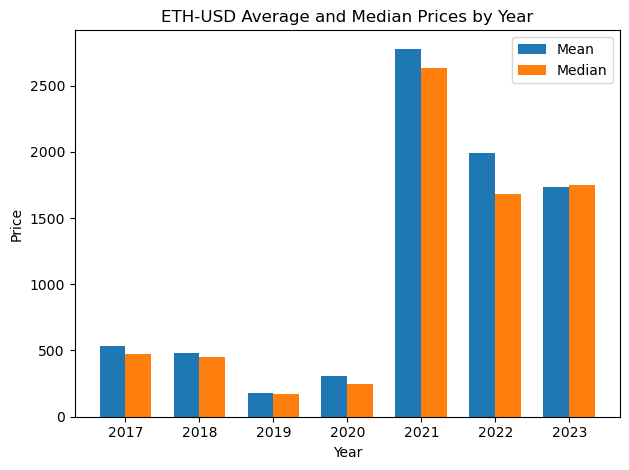

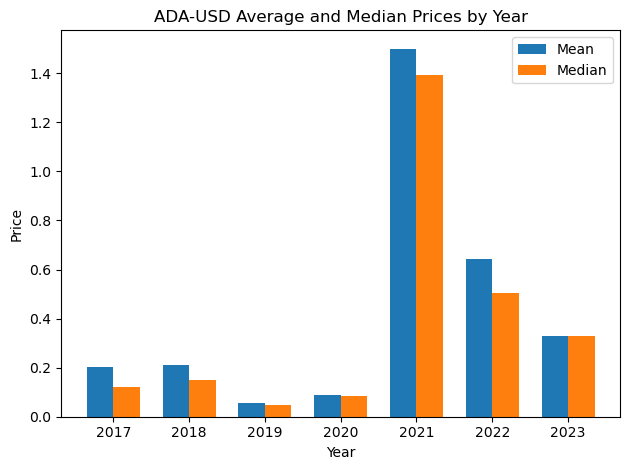

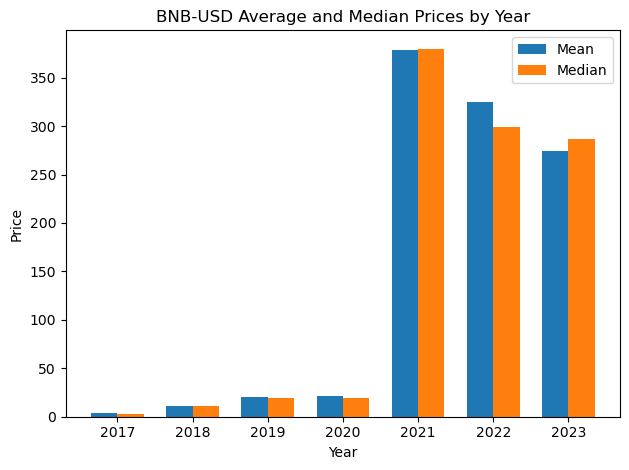

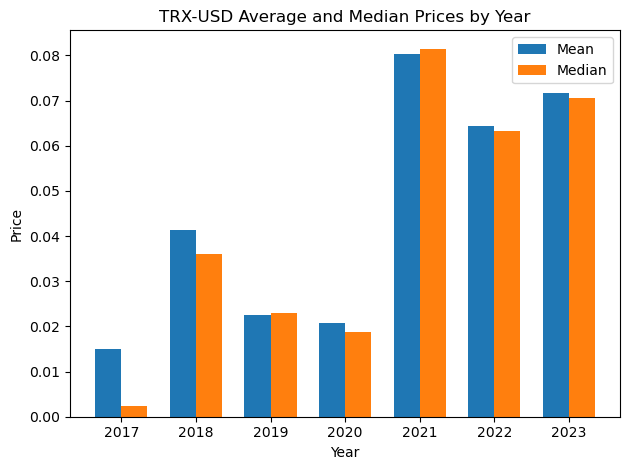

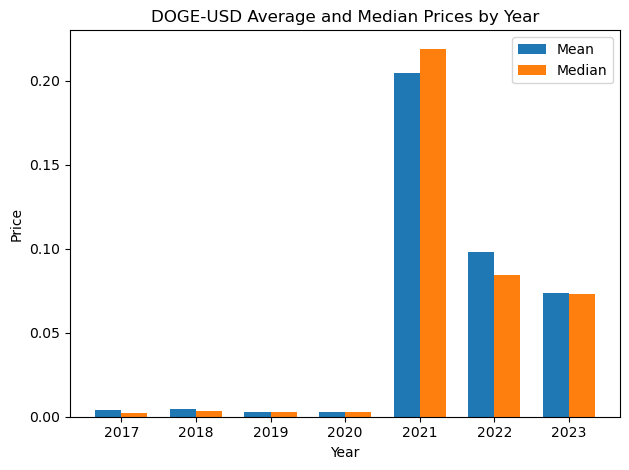

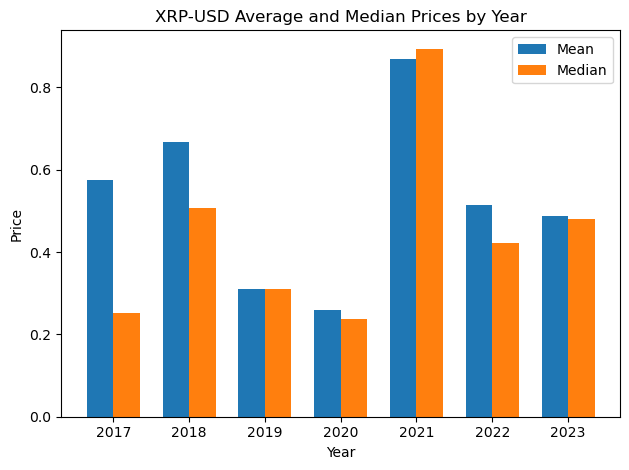

In [27]:
for crypto in cryptos:
    crypto_data = crypt_mean_median[crypt_mean_median['symbol'] == crypto]
    
    years = crypto_data['year']
    mean_prices = crypto_data['mean']
    median_prices = crypto_data['median']
    
    bar_width = 0.35
    index = range(len(years))
    
    fig, ax = plt.subplots()
    
    ax.bar(index, mean_prices, bar_width, label='Mean', align='center')
    ax.bar([i + bar_width for i in index], median_prices, bar_width, label='Median', align='center')
    
    ax.set_xlabel('Year')
    ax.set_ylabel('Price')
    ax.set_title(f'{crypto} Average and Median Prices by Year')
    
    ax.set_xticks([i + bar_width / 2 for i in index])
    ax.set_xticklabels(years)
    
    ax.legend()
    
    plt.tight_layout()
    plt.show()

В срезе по году разница между медианным и средним значением становится не так высока.

## Корреляция между криптовалютами

Посчитаем корреляцию между стоимостью критповалют и визуализируем с помощью тепловой карты

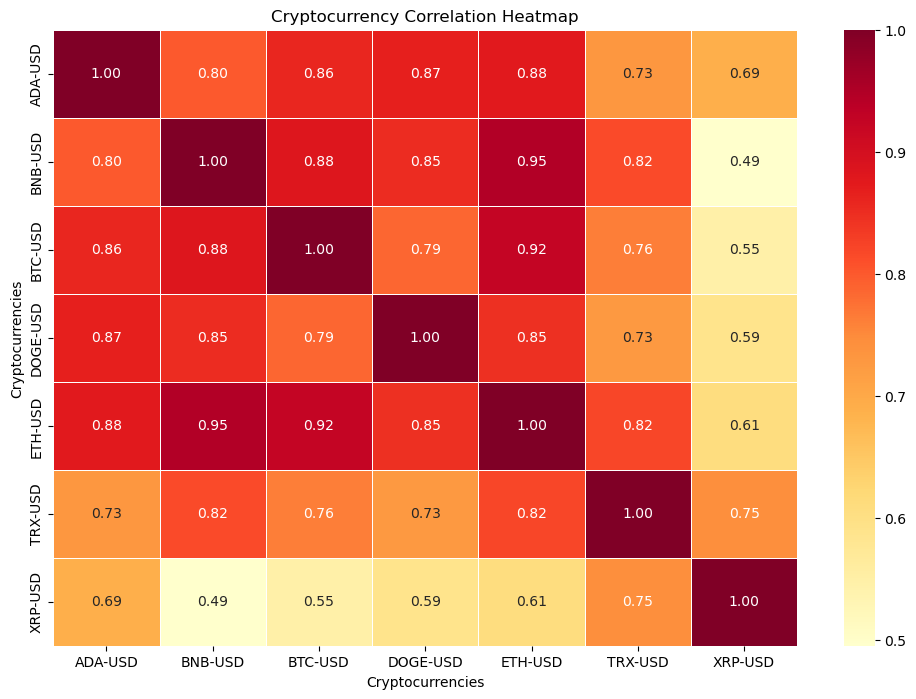

In [28]:

# создаем сводную таблицу для последующего вычисления корреляции
for_crypto_corr_pivot = cryptocurrencies.pivot(index='date', columns='symbol', values='adjclose')

# создаем корреляционную матррицу
crypto_corr = for_crypto_corr_pivot.corr()

# визуализируем  

plt.figure(figsize=(12, 8))
sns.heatmap(crypto_corr, annot=True, fmt='.2f', 
            cmap='YlOrRd', linewidths=0.5)
plt.title('Cryptocurrency Correlation Heatmap')
plt.xlabel('Cryptocurrencies')
plt.ylabel('Cryptocurrencies')
plt.show()

Цены криптовлают высоко коррелируют друг с другом, превышая, в массе своей 0.7 и достигая 0.95

Самая низко коррелируемая криптовалюта является **ripple**. Для Ripple корр. опускается до 0.49 для Binance Coin и поднимается до 0.75 для Tron.

Коэффициент корреляции сам по себе не свидетельсвует о каузации, однако можем попробовать выдвинуть некоторые предположения и заключения, которые стоят за данными цифрами:

1. Общии настроения рынка одинаково влияют на криптовалюты. Если одна криптовалюта вырастет или упадет, то другие, скорее всего, последуют её примеру. Это может выражаться в эффекте толпы, когда трейдеры и инвесторы при финансовых решениях следуют за настроениями рынка, поэтому когда одна криптовалюта возрастает в цене из-за появления каких-нибудь новостей, то эффектом домино возрастают и другие криптовалюты. Однако такая иррациональность может объясняться дефицитом информации/метрик у криптовалют(в отличии от акций!) для анализа и осуществления обоснованного инвестиционного решения, поэтому инвесторы могут опираться на текущую динамику рынка или новости, а затем осуществлять инвестиции в крипту.

2. На стоимость криптовалют может играть общий крипто-фактор: новости, технологические разработки, макроэкономические тенденции, изменения в законодательстве и тд. На каждую из криптовалют по отдельности эти факторы могут оказывать схожее влияние, следствием чего будет похожая ценовая динамика.

3. Криптовалюта плохо диверсифицирует риск в портфеле с иными криптовалютами. 

## Корреляция стоимости акций и криптовалют

In [29]:
# соединяем названия акций и извлекаем уникальные значения в отдельный список
asset_symbols = pd.concat([big_tech_data['symbol'],
                           finance_data['symbol'],
                           retail_data['symbol'],
                           energy_data['symbol'],
                           small_cap['symbol'],
                           sp500['symbol']]).unique()

# создадим пустой словарь, чтобы хранить в нем значения корреляций
correlations = {}

# циклом для каждой криптовалюты и каждой акции считаем корреляцию между доходами
for crypto in cryptos:
    crypto_data = cryptocurrencies[cryptocurrencies['symbol'] == crypto][['date', 'adjclose']]
    
    crypto_correlations = []
    
    # проходимся циклом по каждой акции
    for asset_symbol in asset_symbols:
        # извлекаем датасеты
        for df in [big_tech_data, finance_data, retail_data, energy_data, small_cap, sp500]:
            # в случае, если акция в датасете - извлекаем дату и цену
            if asset_symbol in df['symbol'].values:
                stock_data = df[df['symbol'] == asset_symbol][['date', 'adjclose']]
                break
        
        # Объединяем криптовалюту и акцию по дате
        merged_data = pd.merge(crypto_data, stock_data, on='date', suffixes=('_crypto', '_stock'))
        
        # считаем доход изменения в цене (доход) акций и крипты
        merged_data['returns_crypto'] = merged_data['adjclose_crypto'].pct_change() * 100
        merged_data['returns_stock'] = merged_data['adjclose_stock'].pct_change() * 100
        
        # Считаем корреляцию между криптой и акцией
        correlation = merged_data['returns_crypto'].corr(merged_data['returns_stock'])
        # добавляем корреляцию в пустой список
        crypto_correlations.append(correlation)
    # добавляем в пустой словарь корреляцию для крипты
    correlations[crypto] = crypto_correlations

# конвертируем корреляцию в датафрейм , индексами выступят названия акций
correlations_df = pd.DataFrame(correlations, index=asset_symbols)


Добавим столбец, где будет отображена группа к которой принадлежит акция

In [30]:
# Определим названия групп корреляций
group_names = ['Big Tech', 'Finance', 'Retail', 'Energy', 'Small Cap', 'S&P500']

# Создаим словарь пустой 
stock_labels = {}

#  проходимся по списку датасетов с акциями и индексом
for i, dataset in enumerate(stock_datasets):
    for symbol in dataset['symbol'].unique():
        stock_labels[symbol] = group_names[i]

# создаем новую колонку с названием группы
correlations_df['Asset Group'] = correlations_df.index.map(stock_labels)


In [31]:
correlations_df.style.background_gradient(cmap='Blues')

,BTC-USD,ETH-USD,ADA-USD,BNB-USD,TRX-USD,DOGE-USD,XRP-USD,Asset Group
AAPL,0.211715,0.231633,0.159810,0.164622,0.128074,0.055803,0.146551,Big Tech
AMZN,0.211454,0.216628,0.161370,0.156933,0.097450,0.081941,0.138255,Retail
GOOGL,0.222865,0.236563,0.174619,0.160850,0.121305,0.097939,0.155591,Big Tech
MSFT,0.235807,0.247122,0.161889,0.179075,0.130219,0.111143,0.170802,Big Tech
BAC,0.184521,0.186519,0.154959,0.135577,0.105710,0.100031,0.142475,Finance
GS,0.208116,0.222375,0.164812,0.153020,0.110207,0.113530,0.151343,Finance
JPM,0.184466,0.193702,0.153360,0.139734,0.105299,0.105139,0.140086,Finance
MS,0.209548,0.225384,0.161750,0.150026,0.108860,0.109061,0.163447,Finance
WFC,0.193267,0.186664,0.142576,0.145174,0.115580,0.106318,0.137575,Finance
COST,0.171171,0.170483,0.122515,0.137745,0.088640,0.074288,0.091837,Retail


В рассчитанной корреляции между криптовалютами и акциями нет отрицательной корреляции. То есть, динамика значений сонаправлена.

Выделим для каждой криптовалюты по 5 активов с самой высокой корреляцией: от большей к меньшей. Для каждого акции отметим группу к которой она принадлежит. 

**Bitcoin**: 

1. S&P500 - 0.265 
2. Square\SQ - 0.254 (Small Cap) 
3. PagerDuty\PD - 0.245 (Small Cap)
4. HubSpot\HUBS - 0.242 (Small Cap)
5. Microsoft Corporation\MSFT - 0.235 (Big Tech)

**Ethereum**: 
1. S&P 500 - 0.283
2. Square\SQ - 0.261 (Small cap)
3. PagerDuty\PD - 0.245 (Small Cap)
4. Microsoft Corporation\MSFT - 0.247 (Big Tech)
5. Alphabet Inc. (Google)\ GOOGL - 0.236 (Big Tech)

**Cardano**:
1. PagerDuty\PD - 0.222 (Small Cap)
2. S&P 500 - 0.203
3. Alphabet Inc. (Google)\ GOOGL - 0.174 (Big Tech)
4. Square\SQ - 0.173 (Small Cap)
5. Goldman Sachs Group\GS - 0.164 (Finance)

**Binance Coin**:

1. S&P 500 - 0.213
2. PagerDuty\PD - 0.205 (Small Cap)
3. Square\SQ - 0.193 (Small cap)
4. HubSpot\HUBS - 0.191 (Small Cap)
5. Microsoft Corporation\MSFT - 0.179 (Big Tech)

**Tron**:

1. S&P 500 - 0.151
2. PagerDuty\PD - 0.146 (Small Cap)
3. Beyond Meat\BYND - 0.1303 (Small Cap)
4. Microsoft Corporation\MSFT - 0.1302 (Big Tech)
5. Apple Inc\AAPL - 0.128 (Big Tech)

**Dogecoin**:

1. Square\SQ - 0.163 (Small Cap)
2. HubSpot\HUBS - 0.127 (Small Cap)
3. S&p 500 - 0.123
4. The Home Depot\HD - 0.115 (Retail)
5. Goldman Sachs Group\GS - 0.113 (Finance)

**Ripple**: 

1. Square\SQ - 0.207 (Small Cap)
2. S&P 500 - 0.191
3. PagerDuty\PD - 0.172 (Small Cap)
4. Microsoft Corporation\MSFT - 0.170 (Big Tech)
5. Morgan Stanley\MS - 0.163 (Finance)


Можем отметить, что криптовалюты имеют самую высокую корреляцию преимущественно с индексом S&P 500 и акциями относящимся к группам Small-Cap или Big Tech. Причем к Small-Cap акциий относится больше. 

Из семи криптовалют обнаружилось три, у которых в топ 5 корреляции имеются акции, принадлежащие к иным группам акций:

1. **Cardano**: на пятом месте Goldman Sachs Group(группа Finance)
2. **Dogecoin**: на четвертом месте The Home Depot(группа Retail), на пятом месте Goldman Sachs Group(группам Finance)
3. **Ripple**: на пятом месте Morgan Stanley (группа Finance)

При этом, из 10 компаний, относящимся к Small-Cap топ пять делят между собой три компании:

1. Square: в топе у шести криптовалют, кроме Tron.
2. PeggerDuty: в топе у шести криптовалют, кроме Dogecoin.
3. HubSpot: в топе у трёх криптовалют, кроме Ethereum, Cardano, Tron, Ripple.
4. Beyond Meat: в топе только у Tron.

Big Tech компании, которые разделяют топ: 

1. Microsoft Corporation: в топе у пяти криптовалют, кроме Dogecoin и Cardano.
2. Alphabet Inc. (Google): в топе только у Ethereum и Cardano
3. Apple: в топе только у Tron.

## Про Square и PagerDuty

Познакомимся поближе с деятельностью двух компаний, которые имеют высокую корреляцию с криптовалютами.

[**Square**](https://www.investopedia.com/articles/tech/021017/square.asp)

Американская компания появилась на свет в 2009 году. В 2021 году Square переименовался в Block. Деятельнсоть компании связана с финансовыми сервисами и мобильными платежами. Компания главным образом концентрируется на платежах для малого и среднего бизнеса.

1. Block предлагает бизнесу широкий круг решений в Point of Sales Systems (POS). Square POS дает возможность покупателям расплачиваться, давать чаевые и расписываться на смартфоне или планшете продавца. Продавцы с помощью POS могут обрабатывать платежи, сделанные с помощью наличных, кредитных карт или подарочных карт. Бизнес может использовать приложение POS Square для отправки и отслеживания счетов, кастомизации продукта, получения квитанций по email, применения скидок, администрирование возмещений, доступа к данным о продажах и отслеживания запасов в режиме реального времени. 

В частности, у Block есть **Square for Restaurants**. Отдельная POS система, предназначенная исключительно для ресторанов, которая позволяет управлять заказами, платежами и взаимодействовать с клиентами.


> **Point of Sales:**
> Это понятие покрывает два определение - лоакцию, где клиент совершает(или регистрируется) платеж за товар или услугу и систему обработки клиентских тразакций в ритейле.
К элементам в системе POS можно отнести:
>  1. Регистракций и обработка покупок: учет приобретенных товаров, их количество, цену каждого из них и в совокупности. 
>  2. Обработка платежа. Прием различный форм оплаты покупки: наличные деньги, кредитные или дебитовые карты, электронные кошельки, мобильные платежи etc.
>  3. Управление запасами. Мониторинг заполненности складов, своевременное обновление складов, система оповещений при достижении пола или потолка заполненности товара.
>  4. Аналитический отчеты. Выработка отчетов для принятия бизнес решений и планирования на основе информации о продажах, динамики на складах, метриках unit-экономики.
>  5. Предоставление чеков в электронном или печатном виде клиентам.
>  6. Включение штрихкодов и использование их для идентификации товара.
>  7. Выстраивание отношений с клиентами (CRM). Анализ информации о клиентах и покупок для персонализации предложений, программ лояльности и таргетированной рекламы.
>  8. Интеграция с иными системами. Интеграция с бухгалтерскими системами, системами управления клиентами и иными бизнес-системаи для бесперебойной работы и синхронизации данных.
  
2. [Cash App](https://www.investopedia.com/articles/company-insights/090916/how-square-cash-works-and-makes-money-sq.asp): peer-to-peer платежный сервис, позволяющий осуществлять переводу, торговать акциями или покупать Bitcoin и иное.

3. Square Capital. Позволяет кредитовать малый бизнес, не привязывая их к графикам погашения.

4. Online Payment Processing. Позволяет бизнесу осщуествлять онлайн платежи через свой веб-сайт с использованием API интерфейса Square и инструментов интеграции.

Бизнес Block(Square) тесно связан с криптовалютами. Как писалось выше, через Cash App можно покупать, продавать, держать и переводить Bitcoin внутри приложения. Block также [инвестировал в Bitocin](https://www.fool.com/investing/2022/01/04/what-does-bitcoin-mean-for-block/) свыше 220 млн долларов


**PagerDuty**

Американска компания, которая появилась в 2009 году. Компания предоставляет платформу управления цифровыми операциями, которая помогает бизнесу управлять цифровой инфраструктурой и реагировать на проишествия в режиме реального времени. Компания особенно восстребованная для бизнеса, который полагается на цифровой сервис и, вследствие чего, требуется устойчивая система для поддежрания операционной эффективности и управлениия сбоями.

Некоторые из предложений компании: 

1. Incident Management: помогает бизнесу обнаруживать инциденты на цифровых платформах и реагировать на них, обеспечивая надежность.

2. Event Intelligence: анализирует события и инциденты для предоставления информации, которая может помочь предотвратить сбои в будущем.

3. On-Call Management: управляет графиками дежурств и увдоимляет ответственное лицо в случае сбоя.

4. Integration Capabilities: дает возможность интегрироваться с множеством инструментов мониторинга и совместной работы в целях централизованного оповещения и эффективного разрешения инцидентов.

5. Real-time Analytics: предоставляет бизнесу аналитические отчеты в реальном времени, которые помогают отслеживать и улучшать процессы реагирования на инциденты.

PagerDuty видимой связи с криптовалютами не имеет. Возможно, опосредованно, через своих клиентов заинтересованных в стабильной работе своих цифровых сервисов.


По итогам расчета корреляции у нас отличились две Small-Cap компании - Block(Square) и PagerDuty. Мы познакомились поближе и узнали, чем занимаются две организации. Block вовлечена в мир криптовалют напрямую, а PagerDuty - нет. Какие причины таятся за динамикой цен на акции двух компаний мы не знаем, ведь корреляция не значит каузация. Однако кажется, что вероятность причинно-следственной связи между акциями Block и ценами криптовалют более вероятна, чем между криптовалютами и PagerDuty.

## Криптовалюты, Square и PagerDuty

Отобразим динамику цен двух акций, которые имеют одну из самых высоких корреляций с криптовалютами - Square и PagerDuty. Но для начала избавимся от шумов с помощью скользящего среднего

In [33]:
# создаем функцию для расчета скользящего среднего
def moving_avg(series, window=50):
    return series.rolling(window=window, min_periods=1).mean()
# добавляем столбец с значениями скользящео среднего
cryptocurrencies['sma_adjclose'] = cryptocurrencies.groupby(['symbol', 'date'])['adjclose'].transform(lambda x: moving_avg(x, window=50))

# извлекаем данные акций двух
sq_data = small_cap[small_cap['symbol'] == 'SQ'].copy()
pd_data = small_cap[small_cap['symbol'] == 'PD'].copy()

# применяем нашу функцию со скользящим средним
sq_data['sma_adjclose'] = sq_data.groupby(['symbol', 'date'])['adjclose'].transform(lambda x: moving_avg(x, window=50))
pd_data['sma_adjclose'] = pd_data.groupby(['symbol', 'date'])['adjclose'].transform(lambda x: moving_avg(x, window=50))

Визуализируем: создадим субплот, где будет отражена динамика цен на криптовалюту и две акции. Стоимостл акций и криптовалюты может отличаться во много раз, поэтому мы сделаем две y-оси: слева будут отражены значения стоимости криптовалюты, а справа - акций. В противном случае - на графике не будет отражена динамика для актива, который во много раз отличается в цене: будет прямая линия.

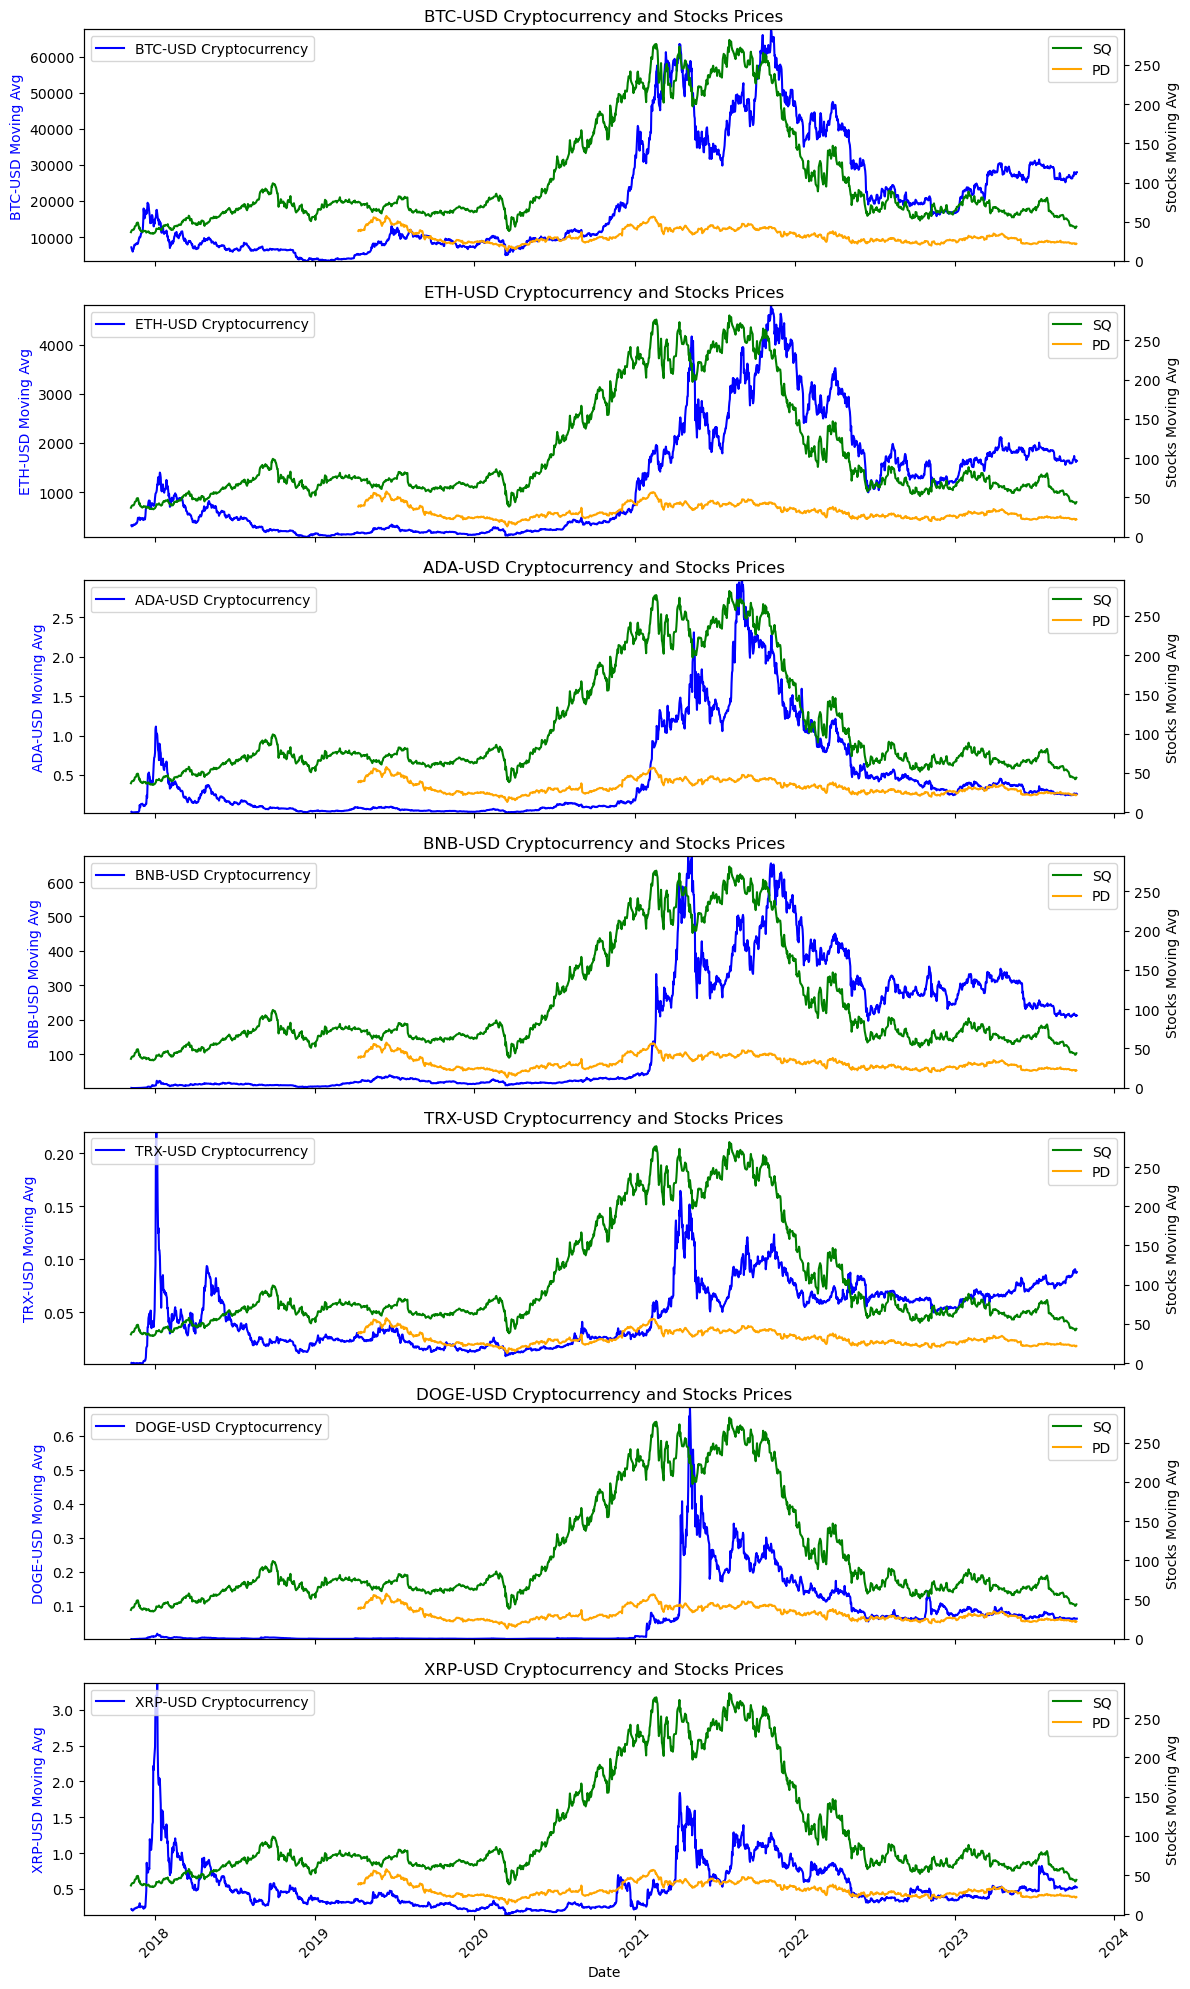

In [34]:




# создаем субплот для каждой криптовалюты
fig, axes = plt.subplots(len(cryptos), 1, figsize=(12, 20), sharex=True)

# приходимся циклом по списку наименований крипттовалют для дальнейшего извлечения данных из датасета
for i, crypto_symbol in enumerate(cryptos):
    # получаем данные
    crypto_data = cryptocurrencies[cryptocurrencies['symbol'] == crypto_symbol]

    
    # считаем минимальное и максимальное значения скользящего среднего, чтобы задать корректную у-ось 
    crypto_y_min = crypto_data['sma_adjclose'].min()
    crypto_y_max = crypto_data['sma_adjclose'].max()
    
    # создаем вторую y-ось для цен акций
    ax2 = axes[i].twinx()
    
    # создаем графики
    # голубая линия - крипта, 
    #зеленая и ораньженвая - акции
    axes[i].plot(crypto_data['date'], crypto_data['sma_adjclose'], label=f'{crypto_symbol} Cryptocurrency', color='blue')
    ax2.plot(sq_data['date'], sq_data['sma_adjclose'], label='SQ', color='green')
    ax2.plot(pd_data['date'], pd_data['sma_adjclose'], label='PD', color='orange')
    
    # настраиваем
    axes[i].set_title(f'{crypto_symbol} Cryptocurrency and Stocks Prices')
    axes[i].set_ylabel(f'{crypto_symbol} Moving Avg', color='blue')
    ax2.set_ylabel('Stocks Moving Avg', color='black')
    axes[i].legend(loc='upper left')
    ax2.legend(loc='upper right')
    axes[i].tick_params(axis='x', rotation=45)
    
    # настраиваем y-ось для каждого графика по отдельности (!) по минимальным и максимальным значениям.
    axes[i].set_ylim(crypto_y_min, crypto_y_max)

# общая ось - с датой
axes[-1].set_xlabel('Date')

plt.tight_layout()
plt.show()


Бегло осматривая, мы видим по линейному графику, мы видим, что акции PD отличаются стабильность, а криптовалюты и акции SQ имеют сонаправленную динамику на некоторых временных диапозонах: например, рост во второй половине 2020 года или падение в 2021 году, а также стремительное падение в конце 2021 – начале 2022 годов. Однако есть и разнонаправленные движения: рост SQ при продолжавшемся падении криптовалюты в 2021 году.

# Общий вывод

Криптовалюты высоко скоррелированны между собой, а коэффициент Пирсона варьируется от 0.7 до 0.95, а минимальные и максимальные значения стоимости криптовалюты синхронизируется с датами ценовых минимумов и максимумов иных криптовалют. Такая схожая динамика может сигнализировать о наличии криптофакторов, которые влияют на стоимость каждой криптовалюты, что требует отдельного изучения. 

Рассчитывая корреляцию с акциями и индексом S&P 500 мы обнаружили, что наибольшую корреляцию криптовалюты имеют с индексом S&P 500, а также акциями Small-Cap и BigTech компаний. Коэффициент корреляции варьируется от 0.15 до 0.29. Среди компаний BigTech компаний самую высокую корреляцию имеют Google и Microsoft, а среди Small-Cap компании Square(она же Block) и PagerDuty. 

Бизнес Square тесно связан с финансовыми услугами и криптовалютами в частности, а именно с Bitcoin, а вот PagerDuty может иметь отношение к крпто-миру лишь опосредованно. Несмотря на то, что Square связан лишь с Bitcoin, акции компании находятся в топ пять у шести из семи криптовалют по коэффициенту Пирсона. Можем предположить, что состояние Биткоина отражается на акциях компании Square и вместе с тем, Биткоин будучи бенчмарком для всех остальных криптовалю, влияет на их стоимость. То есть, между всеми криптовалютами, кроме Биткоина, вероятно, присутствует ложная корреляция – такая, где нет причинно-следственной связи. К ложной корреляцией, по видимому, относится и динамика акций PagerDuty, которая в топе у шести криптовалю по коэффициенту Пирсона, но основная деятельность никак не связана напрямую с криптовалютами. 

Скоррелированность с рыночным агрегированным показателем S&P 500 может свидетельствовать о наличии о связи между общим состоянием фондового рынка и стоимостью криптовалют. Это значит, что криптовалюты могут не быть, как часто думают, тихой гаванью во время шоков на финансовых рынках.

Сама по себе корреляция ни о чём не говорит, кроме схожей динамки значений и не способна раскрыть, что стоит за данными изменениями. Однако может подтолкнуть к дальнейшим изысканиям сложного и запутанного мира финансов с целью понять, как различные факторы воздействуют друг на друга. Нам было бы полезно знать, как влияют на цены крипты и акций действия регулятора, приток розничных инвесторов на биржу во время Covid-19, расширение финансовых технологий, позволяющих торговать со смартфона,  инвестиционные решения институциональных инвесторов или макроэкономические индикаторы. 

Знакомства с корреляцией между криптовалютами и акциями может быть полезно для инвесторов в целях составления диверсифицированного портфеля, выстраивания торговой стратегии и выработки общей интуиции взаимозависимости рынка крипты с мейнстримным фондовым рынком и состоянием экономики.
